# Importing Libraries:

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import random
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import re
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.metrics import roc_curve, auc, log_loss, confusion_matrix,f1_score
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import lightgbm as ltb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")

# Reading Data:

In [2]:
data = pd.read_csv('training_variants')

In [3]:
print(data.shape)
data.head(4)

(3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3


In [4]:
# Text data
data2 = pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [5]:
print(data2.shape)
data2.head(4)

(3321, 2)


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...


In [6]:
# Merging the two datasets on ID:

data_ = pd.merge(data, data2,on='ID', how='left')
data_.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


# Null values :

In [7]:
# Checking null values for [Gene]:

idx = data_['Gene'].isnull().values.any()
if idx == False:
    print('There are NO null values')
else:
    print('There are some null values')

There are NO null values


In [8]:
# Checking null values for [Variation]:

idx = data_['Variation'].isnull().values.any()
if idx == False:
    print('There are NO null values')
else:
    print('There are some null values')

There are NO null values


In [9]:
# Checking null values for [TEXT]:

idx = data_['TEXT'].isnull().values.any()
if idx == False:
    print('There are NO null values')
else:
    print('There are SOME null values')

There are SOME null values


In [10]:
idx1 = data_[data_.isna().any(axis=1)]
print('The following are the NaN values for TEXT:')
idx1

The following are the NaN values for TEXT:


,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


- since there are only 5 points with NaN values, we could drop these ID's. But, we already have small dataset so we have to find a workaround these nan values instead of throwing them.

In [11]:
# Workaround for nan values of [TEXT]: We include the [Gene] type and [Variation] name in the [TEXT] column

data_.loc[data_['TEXT'].isnull(),'TEXT'] = data_['Gene'] +' '+data_['Variation']

In [12]:
idx3 = data_.isnull().values.any()
if idx3 == False:
    print('There are NO null values in the dataset.')
else:
    print('There are SOME null values')

There are NO null values in the dataset.


In [13]:
data_.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


# Splitting Data:

In [14]:
x = data_.drop(["ID","Class"], axis = 1)
y = data_["Class"]

In [15]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,stratify = y,random_state = 0)

In [16]:
xy_train = pd.concat([x_train,y_train], axis = 1)
xy_test = pd.concat([x_test,y_test], axis = 1)

# Data Visualisation:

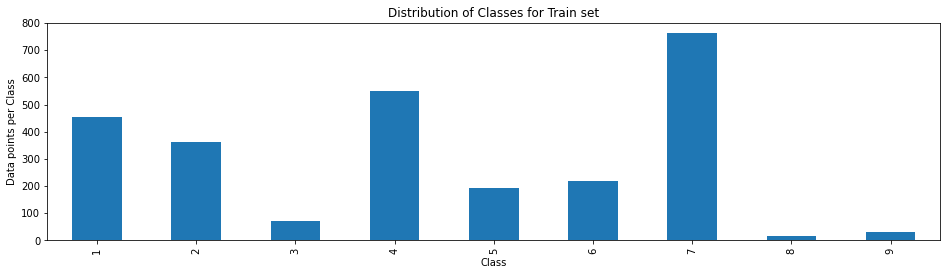

Number of data points in class 7 : 762 ( 22.945 %)
Number of data points in class 4 : 549 ( 16.531 %)
Number of data points in class 1 : 454 ( 13.671 %)
Number of data points in class 2 : 361 ( 10.87 %)
Number of data points in class 6 : 220 ( 6.625 %)
Number of data points in class 5 : 194 ( 5.842 %)
Number of data points in class 3 : 71 ( 2.138 %)
Number of data points in class 9 : 30 ( 0.903 %)
Number of data points in class 8 : 15 ( 0.452 %)


In [17]:
# Training set distribution:
plt.figure(figsize=(16, 4))

class_distribution = xy_train['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
class_distribution.plot(kind='bar')

plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Classes for Train set')
plt.show()
print('='*100)

sorted_class = np.argsort(-class_distribution.values)
for i in sorted_class:
    print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/data.shape[0]*100), 3), '%)')

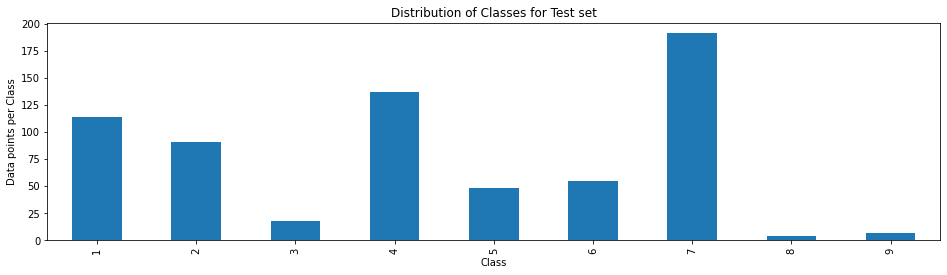

Number of data points in class 7 : 191 ( 5.751 %)
Number of data points in class 4 : 137 ( 4.125 %)
Number of data points in class 1 : 114 ( 3.433 %)
Number of data points in class 2 : 91 ( 2.74 %)
Number of data points in class 6 : 55 ( 1.656 %)
Number of data points in class 5 : 48 ( 1.445 %)
Number of data points in class 3 : 18 ( 0.542 %)
Number of data points in class 9 : 7 ( 0.211 %)
Number of data points in class 8 : 4 ( 0.12 %)


In [18]:
# Test set distribution:

plt.figure(figsize=(16, 4))

class_distribution = xy_test['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
class_distribution.plot(kind='bar')

plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Classes for Test set')
plt.show()
print('='*100)

sorted_class = np.argsort(-class_distribution.values)
for i in sorted_class:
    print('Number of data points in class', i+1, ':',class_distribution.values[i], '(', np.round((class_distribution.values[i]/data.shape[0]*100), 3), '%)')

- Stratify ensures that the distribution of target variable remains the same in both train & test set

# Gene:

In [19]:
genes = xy_train['Gene'].value_counts()
genes1 = len(np.unique(np.array(xy_train["Gene"])))
print('The number of unique Genes in the dataset are:',genes1)
genes.head(10)

The number of unique Genes in the dataset are: 247


BRCA1     211
TP53      127
EGFR      115
PTEN      104
BRCA2      97
BRAF       74
KIT        74
ERBB2      59
ALK        56
PDGFRA     48
Name: Gene, dtype: int64

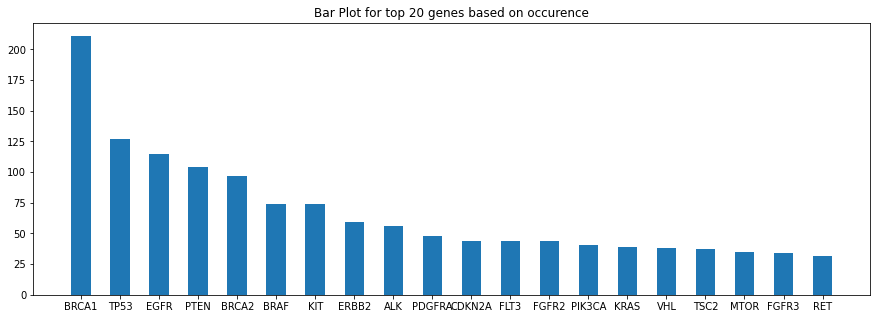

In [20]:
thisdict = (dict(genes))
gene = []
for x in thisdict.keys():
    gene.append(x)

count = []
for y in thisdict.values():
    count.append(y)

plt.figure(figsize=(15, 5))
x_axis = gene[:20]
y_axis = count[:20]
plt.bar(x_axis,y_axis,width = 0.5)
plt.title('Bar Plot for top 20 genes based on occurence')
plt.show()

# Variation:

In [21]:
variation = xy_train['Variation'].value_counts()
variation1 = len(np.unique(np.array(data["Variation"])))
print('The number of unique Variations in the dataset are:',variation1)
variation

The number of unique Variations in the dataset are: 2996


Truncating Mutations    69
Deletion                57
Amplification           57
Fusions                 31
G12V                     4
                        ..
E258V                    1
V559C                    1
R177*                    1
F1761S                   1
E2419K                   1
Name: Variation, Length: 2410, dtype: int64

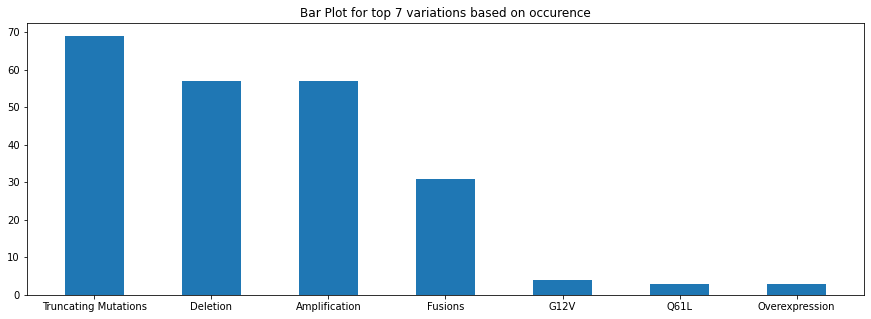

In [22]:
thisdict = (dict(variation))
var = []
for x in thisdict.keys():
    var.append(x)

count = []
for y in thisdict.values():
    count.append(y)

plt.figure(figsize=(15, 5))
x_axis = var[:7]
y_axis = count[:7]
plt.bar(x_axis,y_axis,width = 0.5)
plt.title('Bar Plot for top 7 variations based on occurence')
plt.show()

# Top Gene based on class:

In [23]:
def top_feature_(data,target,feature,class_,top):
    x1 = data.groupby(by = target)
    x2 = x1.get_group(class_)
    x3 = x2[feature].value_counts()
    x4 = list(dict(x3).keys())[:top]
    x5 = list(dict(x3).values())[:top] 
    plt.title('Top {} {} for class {}'.format(top,feature,class_))
    plt.bar(x4,x5,width = 0.2)

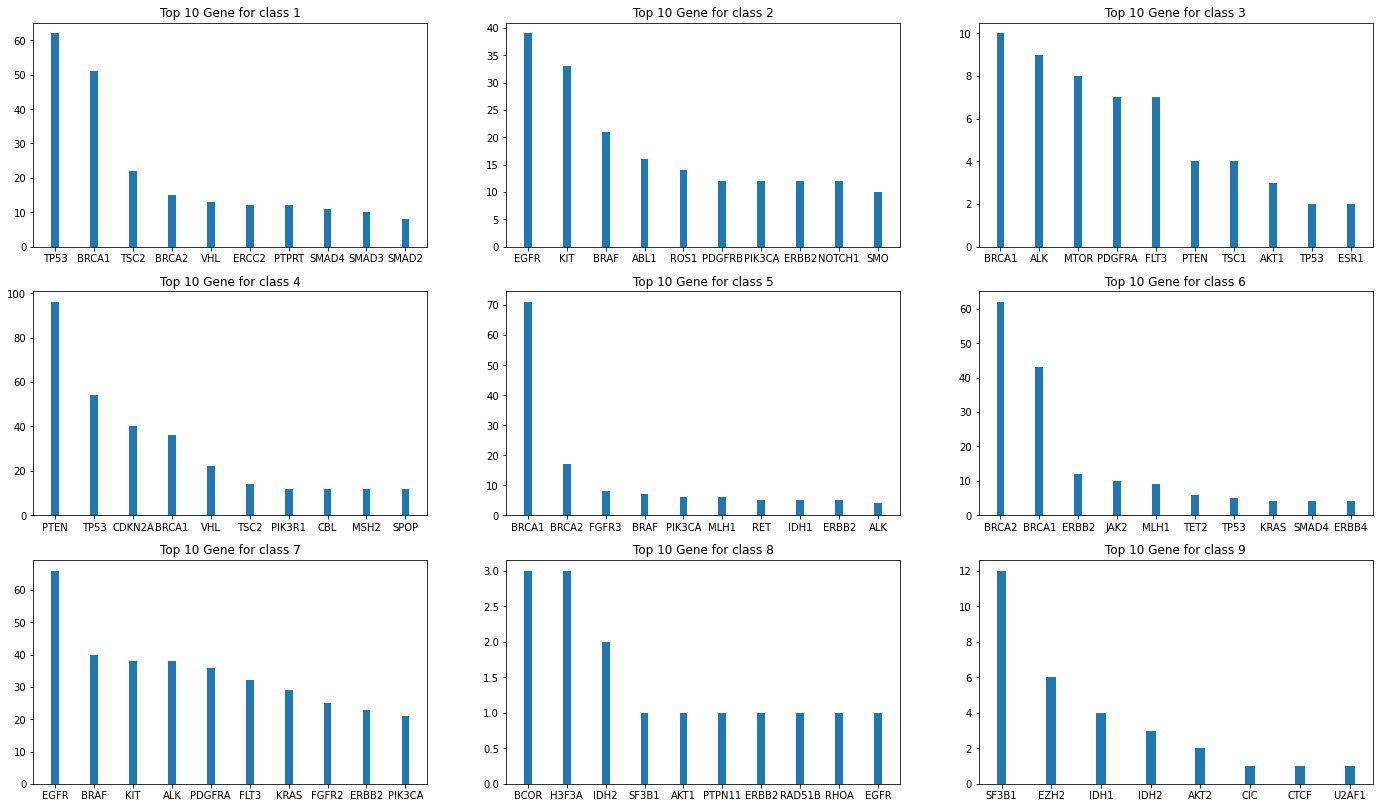

In [24]:
plt.figure(figsize=(24, 14))
plt.subplot(3,3,1)
top_feature_(xy_train,'Class','Gene',1,10)

plt.subplot(3,3,2)
top_feature_(xy_train,'Class','Gene',2,10)

plt.subplot(3,3,3)
top_feature_(xy_train,'Class','Gene',3,10)

plt.subplot(3,3,4)
top_feature_(xy_train,'Class','Gene',4,10)

plt.subplot(3,3,5)
top_feature_(xy_train,'Class','Gene',5,10)

plt.subplot(3,3,6)
top_feature_(xy_train,'Class','Gene',6,10)

plt.subplot(3,3,7)
top_feature_(xy_train,'Class','Gene',7,10)

plt.subplot(3,3,8)
top_feature_(xy_train,'Class','Gene',8,10)

plt.subplot(3,3,9)
top_feature_(xy_train,'Class','Gene',9,10)

# Top Variation based on class:

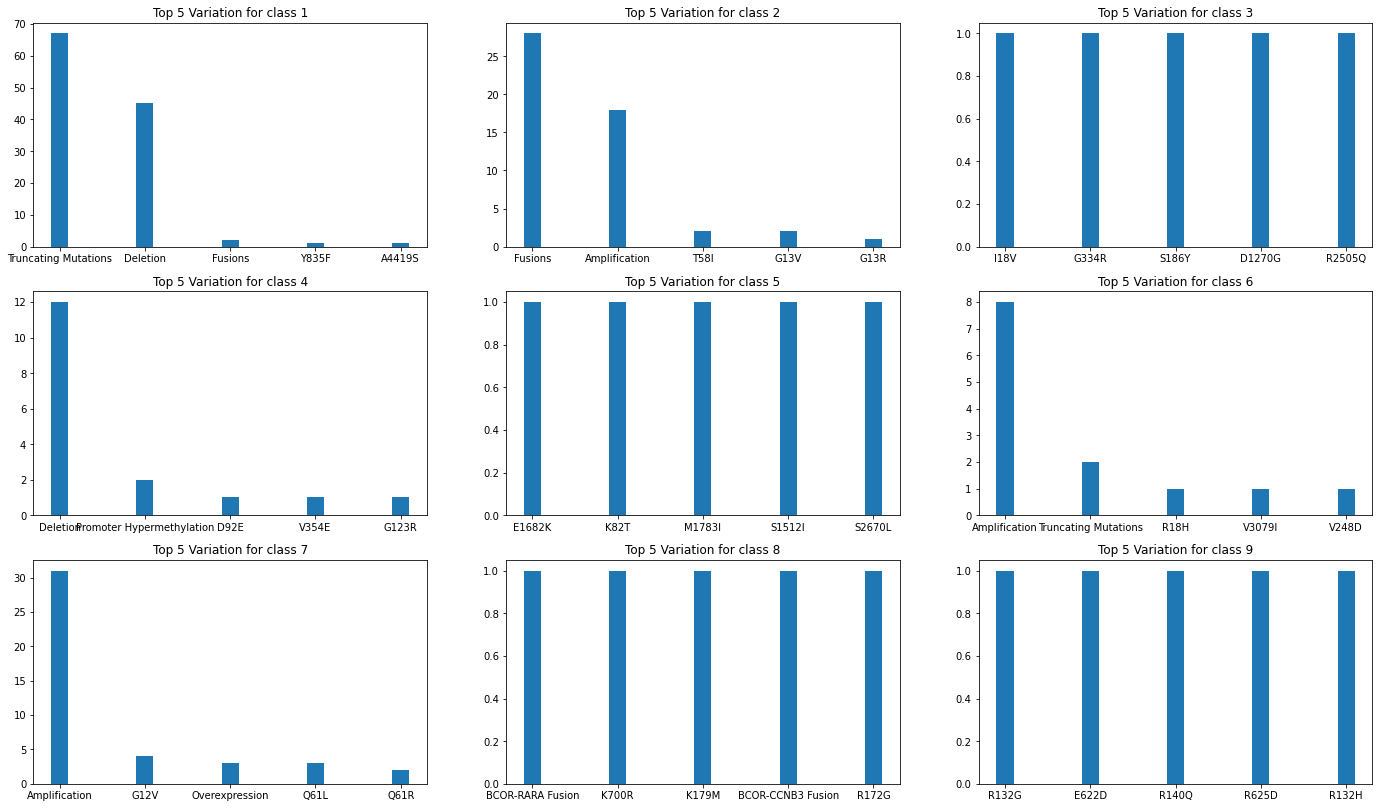

In [25]:
plt.figure(figsize=(24, 14))
plt.subplot(3,3,1)
top_feature_(xy_train,'Class','Variation',1,5)

plt.subplot(3,3,2)
top_feature_(xy_train,'Class','Variation',2,5)

plt.subplot(3,3,3)
top_feature_(xy_train,'Class','Variation',3,5)

plt.subplot(3,3,4)
top_feature_(xy_train,'Class','Variation',4,5)

plt.subplot(3,3,5)
top_feature_(xy_train,'Class','Variation',5,5)

plt.subplot(3,3,6)
top_feature_(xy_train,'Class','Variation',6,5)

plt.subplot(3,3,7)
top_feature_(xy_train,'Class','Variation',7,5)

plt.subplot(3,3,8)
top_feature_(xy_train,'Class','Variation',8,5)

plt.subplot(3,3,9)
top_feature_(xy_train,'Class','Variation',9,5)

# Feature Extraction:

In [26]:
def character_count(text):
    """
    This function returns the number of letters in a review
    
    """
    return len(text)

def word_count(text):
    """
    This function returns the number of words in a review
    
    """
    return len(text.split())

def unique_words(text):
    """
    This function returns the number of unique words in a review
    
    """
    return len(set(text.split()))

def stopwords_count(text):
    """
    This function returns the number of stop words present in a review
    
    """
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

In [27]:
# Train set

xy_train['char_count'] = xy_train["TEXT"].apply(lambda x:character_count(x))
xy_train['word_count'] = xy_train["TEXT"].apply(lambda x:word_count(x))
xy_train['unique_word_count'] = xy_train["TEXT"].apply(lambda x:unique_words(x))
xy_train['stopword_count'] = xy_train["TEXT"].apply(lambda x:stopwords_count(x))

xy_train['avg_wordlength'] = xy_train['char_count']/xy_train['word_count']
xy_train['unique_vs_words'] = xy_train['unique_word_count']/xy_train['word_count']
xy_train['stopwords_vs_words'] = xy_train['stopword_count']/xy_train['word_count']

In [28]:
# Test set

xy_test['char_count'] = xy_test["TEXT"].apply(lambda x:character_count(x))
xy_test['word_count'] = xy_test["TEXT"].apply(lambda x:word_count(x))
xy_test['unique_word_count'] = xy_test["TEXT"].apply(lambda x:unique_words(x))
xy_test['stopword_count'] = xy_test["TEXT"].apply(lambda x:stopwords_count(x))

xy_test['avg_wordlength'] = xy_test['char_count']/xy_test['word_count']
xy_test['unique_vs_words'] = xy_test['unique_word_count']/xy_test['word_count']
xy_test['stopwords_vs_words'] = xy_test['stopword_count']/xy_test['word_count']

# Data Cleaning:

In [29]:
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to C:\Users\PANCHAYAT
[nltk_data]     SAMITI 01\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
stop_words.add('also')
stop_words.add('using')
stop_words.add('fig')
stop_words.add('the')
stop_words.add('expression')
stop_words.add('type')
stop_words.add('using')
stop_words.add('we')
stop_words.add('may')
stop_words.add('shown')
stop_words.add('however')
stop_words.add('to')
stop_words.add('these')
stop_words.add('well')

In [31]:
# Cleaning the [TEXT]:

def clean(text):
    '''
    This function gets rid of all punctuation marks, special characters, stop words
    and expands the contracted words and returns words after applying stemming
    
    '''
    sent = text.lower().strip()
    sent = re.sub('[^a-zA-Z]',' ',text)
    sent = sent.split()
    final = [word for word in sent if not word in set(stop_words)]
    final_sent =  ' '.join(final)
    return final_sent

In [32]:
train_text = [] 
for z in tqdm(range(len(xy_train.TEXT.values))):
    r1 = clean((xy_train.TEXT.values[z]))
    train_text.append(r1)


100%|██████████████████████████████████████████████████████████████████████████████| 2656/2656 [01:18<00:00, 33.89it/s]


In [33]:
test_text = [] 
for z in tqdm(range(len(xy_test.TEXT.values))):
    r1 = clean((xy_test.TEXT.values[z]))
    test_text.append(r1)


100%|████████████████████████████████████████████████████████████████████████████████| 665/665 [00:19<00:00, 33.92it/s]


In [34]:
# Adding the cleaned TEXT in the dataset:
xy_train['TEXT'] = train_text
xy_test['TEXT'] = test_text

In [35]:
xy_train.to_csv("final_train")
xy_test.to_csv("final_test")

In [36]:
#xy_train = pd.read_csv("final_train")
#xy_test = pd.read_csv("final_test")

# Visualization on Text:

In [37]:
def get_top_ngram(corpus, n,count_):
    """
    This function returns a list of tuples, where the first element in tuple is the word 
    and the second element is the frequency of that in the corpus
    
    """
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus) # initialize the countvectorizer
    bag_of_words = vec.transform(corpus) # fitting on the corpus
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()] # list of tuples as mentioned above
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) # sorting the list in descending order, to get 
                                                                       # higher frequency words first.
    return words_freq[:count_] # we return the top 30 grams with high frequency

<AxesSubplot:>

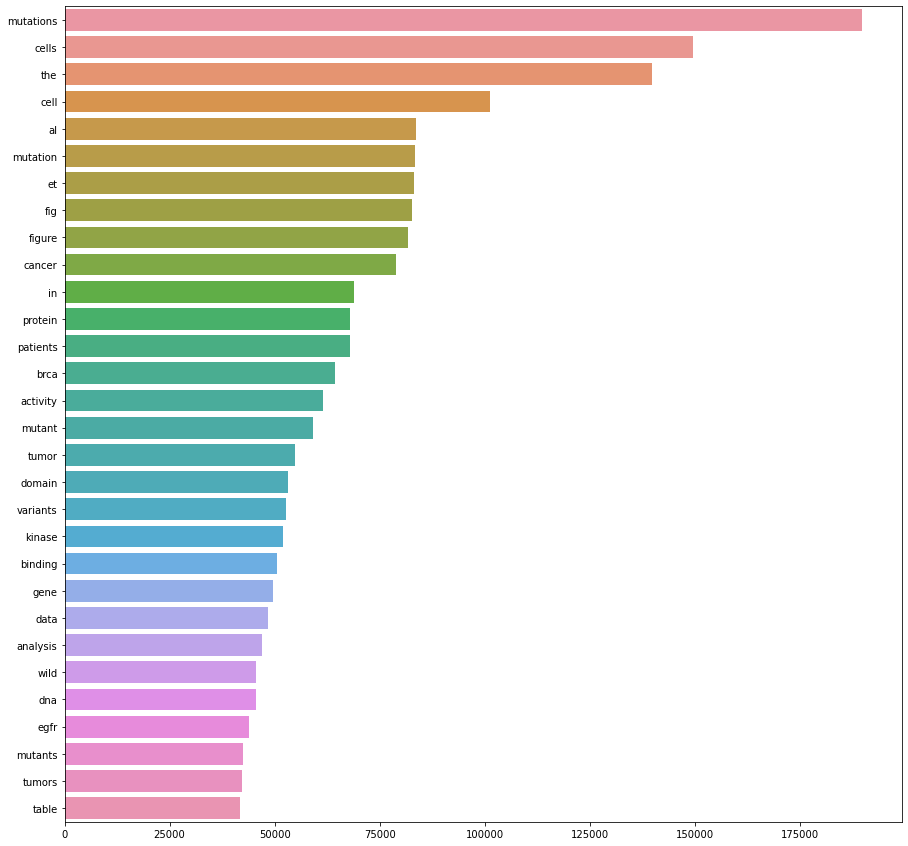

In [38]:
# Here we see the top unigrams
top_n_bigrams=get_top_ngram(xy_train['TEXT'],1,30)

plt.figure(figsize=(15, 15))
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)

<AxesSubplot:>

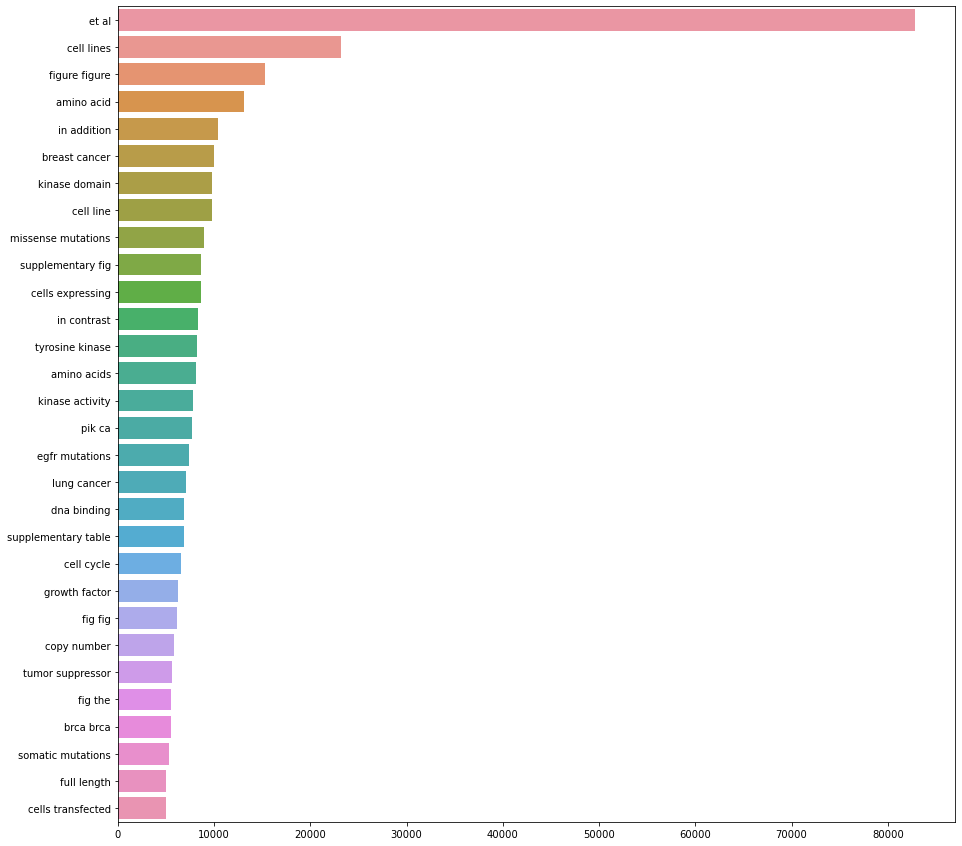

In [39]:
# Here we see the top bi-grams.
top_n_bigrams=get_top_ngram(xy_train['TEXT'],2,30)

plt.figure(figsize=(15, 15))
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)

In [40]:
def wordcloud(data,class_):
    x1 = data.groupby(by = "Class")
    x2 = x1.get_group(class_)
    words = ''
    for j in (x2["TEXT"].values): # This loop extracts words from sentences given to it as input
        c = (str(j).split())
        for v in c:
            b = v.lower()
            words += "".join(b)+" "
    
    wc_q = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stop_words,min_font_size = 10)
    wc_q.generate(words)
    plt.title("Wordcloud for class {}".format(class_), fontsize = 20)
    plt.axis("off")
    plt.imshow(wc_q, interpolation='bilinear')

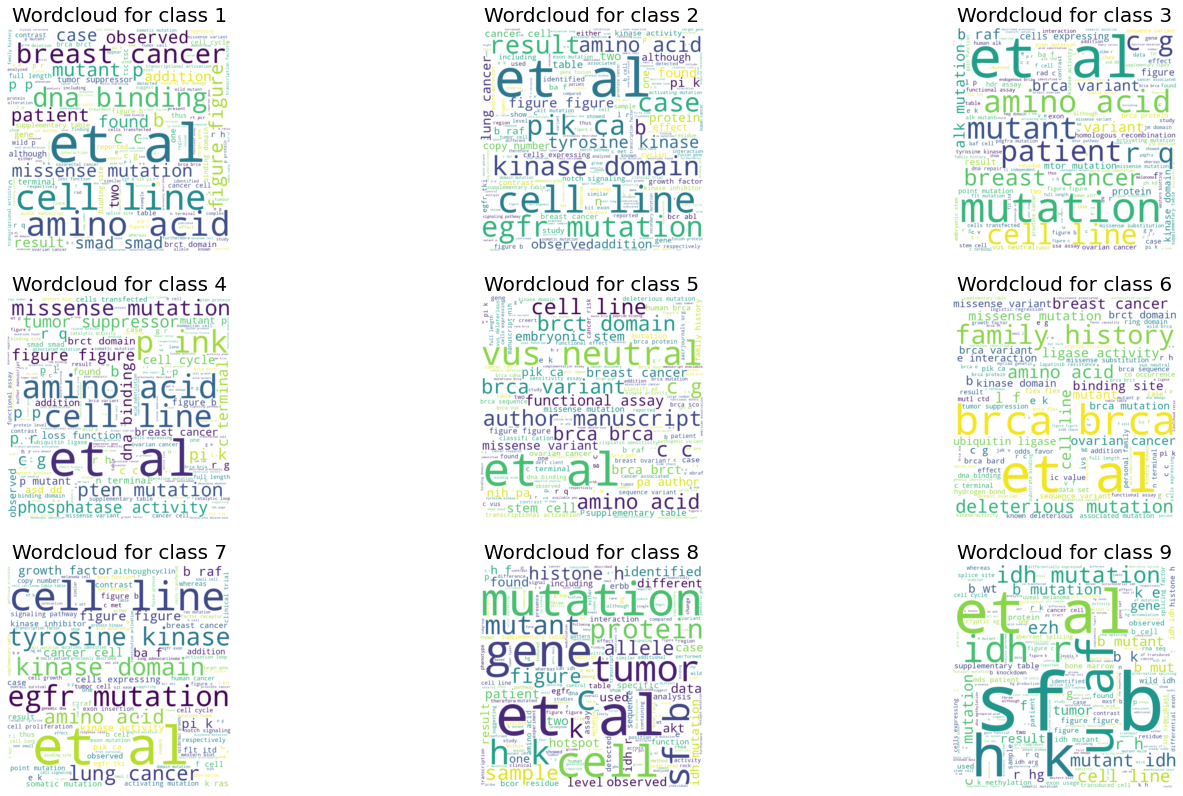

In [41]:
plt.figure(figsize=(24, 14))
plt.subplot(3,3,1)
wordcloud(xy_train,1)

plt.subplot(3,3,2)
wordcloud(xy_train,2)

plt.subplot(3,3,3)
wordcloud(xy_train,3)

plt.subplot(3,3,4)
wordcloud(xy_train,4)

plt.subplot(3,3,5)
wordcloud(xy_train,5)

plt.subplot(3,3,6)
wordcloud(xy_train,6)

plt.subplot(3,3,7)
wordcloud(xy_train,7)

plt.subplot(3,3,8)
wordcloud(xy_train,8)

plt.subplot(3,3,9)
wordcloud(xy_train,9)

In [42]:
xy_train.head(1)

,Gene,Variation,TEXT,Class,char_count,word_count,unique_word_count,stopword_count,avg_wordlength,unique_vs_words,stopwords_vs_words
2216,PTEN,D92E,The PTEN phosphatase tensin homolog phosphatas...,4,42789,6351,1715,2129,6.737364,0.270036,0.335223


In [43]:
def distribution(feature):
    x1 = xy_train.groupby(by = "Class")
    c1 = x1.get_group(1)
    c2 = x1.get_group(2)
    c3 = x1.get_group(3)
    c4 = x1.get_group(4)
    c5 = x1.get_group(5)
    c6 = x1.get_group(6)
    c7 = x1.get_group(7)
    c8 = x1.get_group(8)
    c9 = x1.get_group(9)

    plt.figure(figsize=(12, 5))
    plt.title("Distribution of {} for various class".format(feature))
    sns.kdeplot(c1[feature],shade=True, label = 'class 1',legend = True)
    sns.kdeplot(c2[feature],shade=True, label = 'class 2',legend = True)
    sns.kdeplot(c3[feature],shade=True, label = 'class 3',legend = True)
    sns.kdeplot(c4[feature],shade=True, label = 'class 4',legend = True)
    sns.kdeplot(c5[feature],shade=True, label = 'class 5',legend = True)
    sns.kdeplot(c6[feature],shade=True, label = 'class 6',legend = True)
    sns.kdeplot(c7[feature],shade=True, label = 'class 7',legend = True)
    sns.kdeplot(c8[feature],shade=True, label = 'class 8',legend = True)
    sns.kdeplot(c9[feature],shade=True, label = 'class 9',legend = True)
    plt.legend()

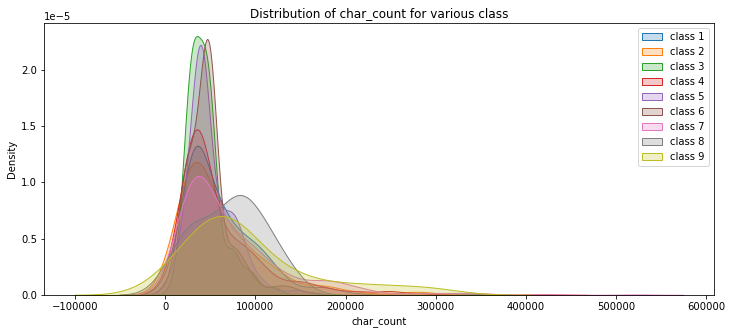

In [44]:
distribution("char_count")

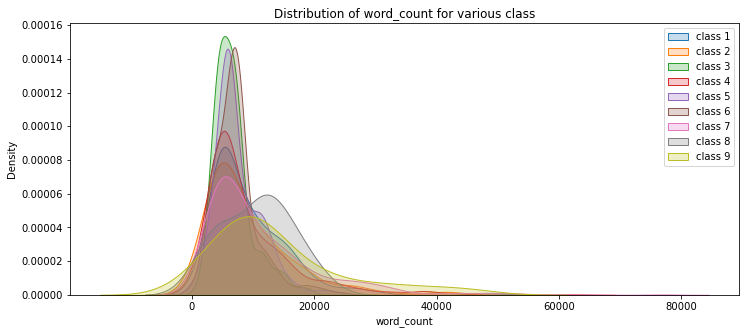

In [45]:
distribution("word_count")

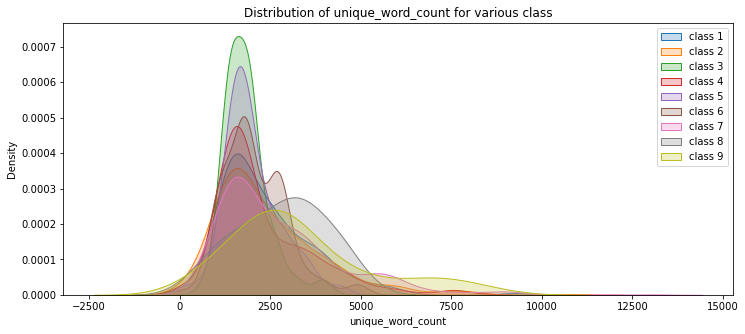

In [46]:
distribution("unique_word_count")

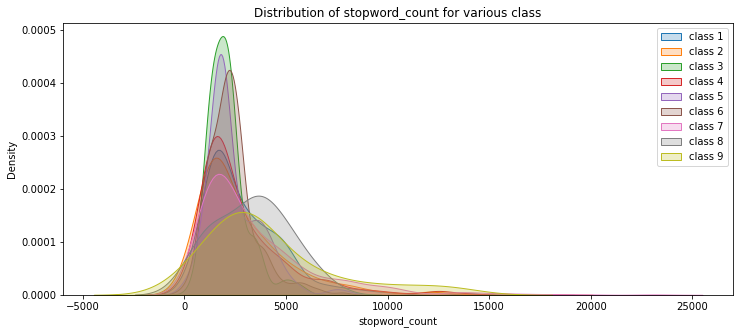

In [47]:
distribution("stopword_count")

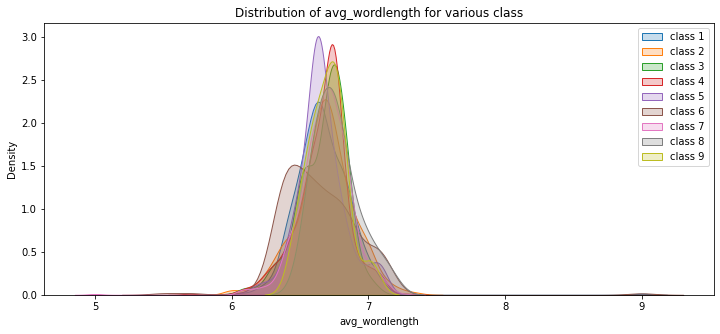

In [48]:
distribution("avg_wordlength")

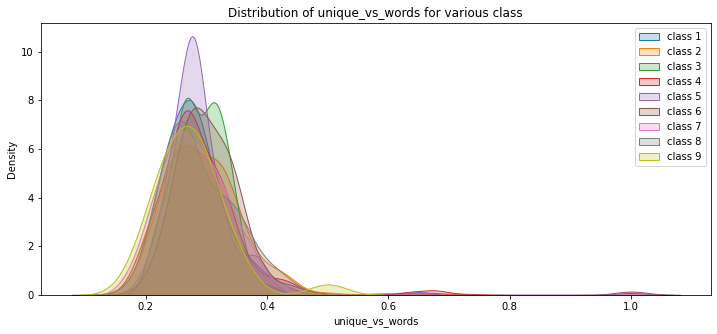

In [49]:
distribution("unique_vs_words")

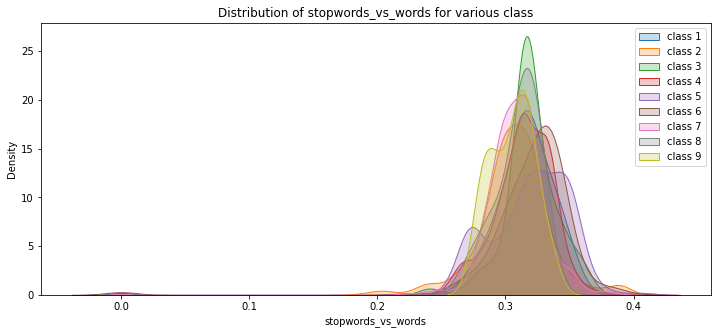

In [50]:
distribution("stopwords_vs_words")

# Confusion matrix, Precision,Recall:

In [51]:
def conufsion_precision_recall(y_actual, y_predict):
    '''
    This function plots the confusion matrix, recall & precision
    
    '''
    C = confusion_matrix(y_actual, y_predict)     
    
    precision =(C/C.sum(axis=0)) # dividing each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    # sum of column elements = 1
    
    recall =(((C.T)/(C.sum(axis=1))).T) # dividing each element of the confusion matrix with the sum of elements in that row
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    

    labels = [1,2,3,4,5,6,7,8,9] # since we have 9 classes

    # Confusion Matrix
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    plt.figure(figsize=(20,5))
    sns.heatmap(precision, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Precision Matrix')
    plt.show()
    
    plt.figure(figsize=(20,5))
    sns.heatmap(recall, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Recall Matrix')
    plt.show()

# Data Preprocessing: 

# Response Coding:

In [52]:
def response_code(alpha,feature, data):
    ''' 
    This function creates a 9 dimensional vector(9 classes) of probability values for the given Gene/Variation as input
    
    '''
    value_count = xy_train[feature].value_counts() # we only use (x_train) for creating the probability vector and keep the
                                                  # test dataset unseen for avoiding data leakage
    gv_dict = dict() # this dictionary has key: Gene/variation & value: probability values for 9 different classes
    # number is the count of a particular feature(gene/variation) that occurs in the dataset
    
    for i, number in value_count.items(): # value_count.items---> it gives a key,Value pair
        vec = [] # this list contains the probability of a gene belonging to different classes(9)
        
        for k in range(1,10): # this loop runs for each class (9)
            count = xy_train.loc[(xy_train[feature]==i) & (xy_train['Class']==k)] 
            vec.append((count.shape[0] + alpha*1)/ (number + 9*alpha))
        '''
        ((Number of rows where feature = i & class = k) + 1*alpha)/((number of times we see feature = i) + 9*alpha)
        '''
        gv_dict[i]=vec # adding the gene/variation to the dict as key and vec(probability values of 9 classes) as value
    return gv_dict

def call_response_coded_feature(alpha, feature, data):
    ''' For a given feature this function returns probability vector if that feature is present in dataset
        If the feature is not present in the dataset then it returns uniform probability of (1/9)
    '''
    
    probability = response_code(alpha, feature, data) # calling the function to get probability vector
    value_count = xy_train[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the probabilities for each feature value in the data
    gv_fea = []
    
    for index, row in data.iterrows():
        if row[feature] in dict(value_count).keys(): 
            gv_fea.append(probability[row[feature]]) # if gene is already present in the dictionary we created then append 
                                                     # the corresponding probability values
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9]) # if gene not present then append (1/9) as probability for each class
    return gv_fea

In [53]:
# Response Coding on Gene

alpha = 1
gene_train_orig = np.array(call_response_coded_feature(alpha,'Gene', xy_train))
gene_test_orig = np.array(call_response_coded_feature(alpha,'Gene', xy_test))

print('Original train data shape',gene_train_orig.shape)
print('='*100)
print('Original test data shape',gene_test_orig.shape)
print('='*100)

Original train data shape (2656, 9)
Original test data shape (665, 9)


In [54]:
# Response Coding on Variation:

variation_train_orig =  np.array(call_response_coded_feature(alpha,'Variation', xy_train))
variation_test_orig = np.array(call_response_coded_feature(alpha,'Variation', xy_test))

print('Original train data shape',variation_train_orig.shape)
print('='*100)
print('Original test data shape',variation_test_orig.shape)
print('='*100)

Original train data shape (2656, 9)
Original test data shape (665, 9)


In [55]:
# TF-IDF on TEXT:

tfidf = TfidfVectorizer(min_df=20,ngram_range=(1,3), max_features=1000)

text_train_orignal = tfidf.fit_transform(xy_train['TEXT'].values)
text_test_orignal = tfidf.transform(xy_test['TEXT'].values)

print('After TF-IDF')
print('Original train text data shape',text_train_orignal.shape)
print('='*100)
print('Original test text data shape',text_test_orignal.shape)

After TF-IDF
Original train text data shape (2656, 1000)
Original test text data shape (665, 1000)


# Normalization:

In [56]:
# char count

scaled_a = MinMaxScaler()
scaled_a.fit(xy_train['char_count'].values.reshape(-1,1))

char_count_train_orig = scaled_a.transform(xy_train['char_count'].values.reshape(-1,1))
char_count_test_orig = scaled_a.transform(xy_test['char_count'].values.reshape(-1,1))

In [57]:
# word count

scaled_b = MinMaxScaler()
scaled_b.fit(xy_train['word_count'].values.reshape(-1,1))

word_count_train_orig = scaled_b.transform(xy_train['word_count'].values.reshape(-1,1))
word_count_test_orig = scaled_b.transform(xy_test['word_count'].values.reshape(-1,1))

In [58]:
# unique_word_count

scaled_c = MinMaxScaler()
scaled_c.fit(xy_train['unique_word_count'].values.reshape(-1,1))

unique_word_count_train_orig = scaled_c.transform(xy_train['unique_word_count'].values.reshape(-1,1))
unique_word_count_test_orig = scaled_c.transform(xy_test['unique_word_count'].values.reshape(-1,1))

In [59]:
# stopword_count

scaled_d = MinMaxScaler()
scaled_d.fit(xy_train['stopword_count'].values.reshape(-1,1))

stopword_count_train_orig = scaled_d.transform(xy_train['stopword_count'].values.reshape(-1,1))
stopword_count_test_orig = scaled_d.transform(xy_test['stopword_count'].values.reshape(-1,1))

In [60]:
# avg_wordlength

scaled_e = MinMaxScaler()
scaled_e.fit(xy_train['avg_wordlength'].values.reshape(-1,1))

avg_wordlength_train_orig = scaled_e.transform(xy_train['avg_wordlength'].values.reshape(-1,1))
avg_wordlength_test_orig = scaled_e.transform(xy_test['avg_wordlength'].values.reshape(-1,1))

In [61]:
# unique_vs_words

scaled_f = MinMaxScaler()
scaled_f.fit(xy_train['unique_vs_words'].values.reshape(-1,1))

unique_vs_words_train_orig = scaled_f.transform(xy_train['unique_vs_words'].values.reshape(-1,1))
unique_vs_words_test_orig = scaled_f.transform(xy_test['unique_vs_words'].values.reshape(-1,1))

In [62]:
# stopwords_vs_words

scaled_g = MinMaxScaler()
scaled_g.fit(xy_train['stopwords_vs_words'].values.reshape(-1,1))

stopwords_vs_words_train_orig = scaled_g.transform(xy_train['stopwords_vs_words'].values.reshape(-1,1))
stopwords_vs_words_test_orig = scaled_g.transform(xy_test['stopwords_vs_words'].values.reshape(-1,1))

In [63]:
y_train = xy_train["Class"]
y_test = xy_test["Class"]

# Concatenating the features:

In [64]:
X_train = hstack((gene_train_orig,variation_train_orig,text_train_orignal,char_count_train_orig,
                     word_count_train_orig,unique_word_count_train_orig,stopword_count_train_orig,
                     avg_wordlength_train_orig,unique_vs_words_train_orig,stopwords_vs_words_train_orig)).tocsr()

X_test = hstack((gene_test_orig,variation_test_orig,text_test_orignal,char_count_test_orig,word_count_test_orig,
                    unique_word_count_test_orig,stopword_count_test_orig,avg_wordlength_test_orig,
                    unique_vs_words_test_orig,stopwords_vs_words_test_orig)).tocsr()

print("Final Data matrix")
print("="*100)
print('Train data shape:',X_train.shape, y_train.shape)
print("="*100)
print('Test data shape:',X_test.shape, y_test.shape)

Final Data matrix
Train data shape: (2656, 1025) (2656,)
Test data shape: (665, 1025) (665,)


In [65]:
np.save("X_train_final_ff",X_train)
np.save("X_test_final_ff",X_test)
np.save("y_train_final_ff",y_train)
np.save("y_test_final_ff",y_test)

# Baseline Models:

# Naive Bayes:

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 15.00it/s]


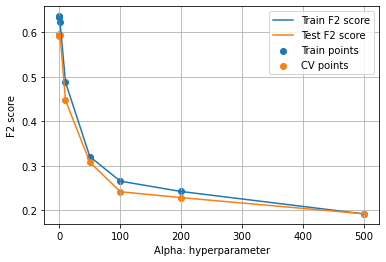

In [66]:
new_train_auc = [] # this stores the training scores
cv_auc = [] # this stores the CV scores

alpha = [0.01,0.05,0.1,1,10,50,100,200,500] # trying different values of alpha to find the best one
for i in tqdm(alpha):
    naive = MultinomialNB(alpha=i)
    naive.fit(X_train, y_train)

    y_newtrain_pred =  naive.predict(X_train)
    y_cv_pred = naive.predict(X_test)
     
    new_train_auc.append(fbeta_score(y_train,y_newtrain_pred,beta = 2,average = 'weighted'))
    cv_auc.append(fbeta_score(y_test,y_cv_pred,beta = 2,average = 'weighted'))

plt.plot(alpha, new_train_auc, label='Train F2 score')
plt.plot(alpha, cv_auc, label='Test F2 score')

plt.scatter(alpha, new_train_auc, label='Train points')
plt.scatter(alpha, cv_auc, label='CV points')

plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("F2 score")
plt.grid()
plt.show()

In [67]:
for i,j in zip(alpha,cv_auc):
    print("For alpha = {}; F2 score = {}".format(i,j))
    

For alpha = 0.01; F2 score = 0.5918926371866315
For alpha = 0.05; F2 score = 0.5931050009692336
For alpha = 0.1; F2 score = 0.5959796452860752
For alpha = 1; F2 score = 0.5947228674079639
For alpha = 10; F2 score = 0.4470090046357002
For alpha = 50; F2 score = 0.30786938186305907
For alpha = 100; F2 score = 0.24149227881739993
For alpha = 200; F2 score = 0.2282641571946925
For alpha = 500; F2 score = 0.19194767885423844


- Best alpha = 0.1

In [68]:
naive_best = MultinomialNB(alpha=0.1)
naive_best.fit(X_train, y_train)
y_newtrain_pred =  naive_best.predict(X_train)
y_cv_pred = naive_best.predict(X_test)
     
test_f2 = (fbeta_score(y_test,y_cv_pred,beta = 2,average = 'weighted'))
print("F2 score = {}".format(test_f2))

F2 score = 0.5959796452860752


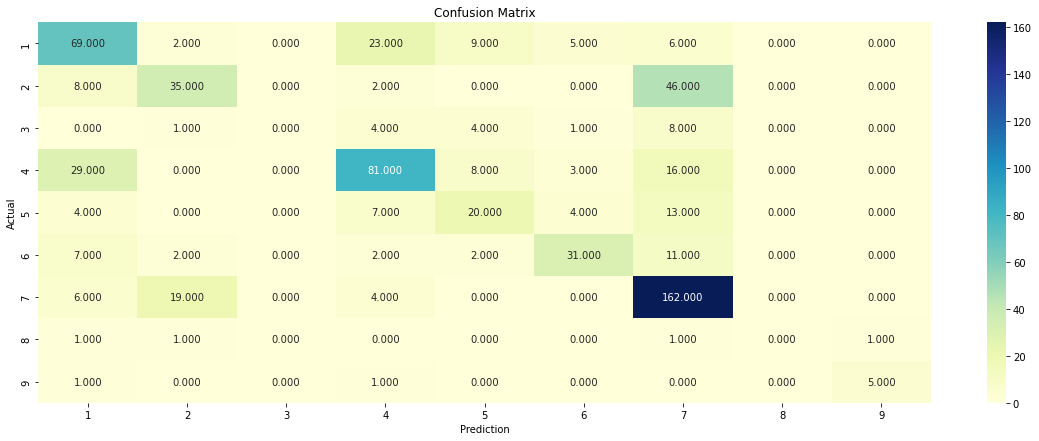

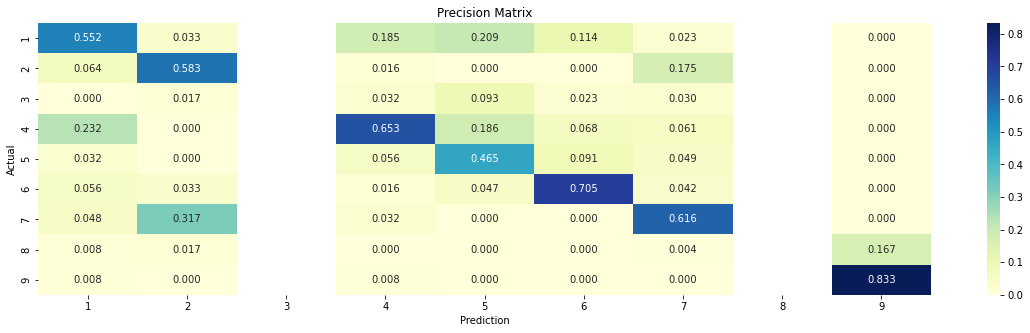

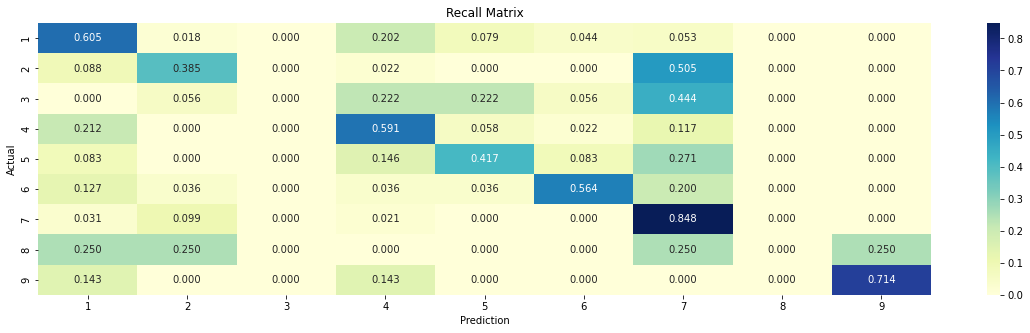

In [69]:
conufsion_precision_recall(y_test,y_cv_pred)

# KNN

In [70]:
def objective(trial):

    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    n_neighbors = trial.suggest_int("n_neighbors", 2, 400)
    algorithm = trial.suggest_categorical("algorithm", ["auto","ball_tree","kd_tree"])

    knn = KNeighborsClassifier(weights = weights, n_neighbors = n_neighbors, algorithm = algorithm)

    score = cross_val_score(knn, X_train, y_train, n_jobs=-1, cv=5,scoring = 'f1_weighted')
    accuracy = score.mean()
    return accuracy

In [71]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

[I 2022-08-29 21:05:36,642] A new study created in memory with name: no-name-cfc28f21-4e4a-495e-b13f-f21798f87a39
[I 2022-08-29 21:05:55,832] Trial 0 finished with value: 0.7618505034559797 and parameters: {'weights': 'distance', 'n_neighbors': 56, 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.7618505034559797.
[I 2022-08-29 21:05:59,888] Trial 1 finished with value: 0.5622443507725619 and parameters: {'weights': 'uniform', 'n_neighbors': 254, 'algorithm': 'auto'}. Best is trial 0 with value: 0.7618505034559797.
[I 2022-08-29 21:06:04,526] Trial 2 finished with value: 0.5516270668080534 and parameters: {'weights': 'uniform', 'n_neighbors': 275, 'algorithm': 'kd_tree'}. Best is trial 0 with value: 0.7618505034559797.
[I 2022-08-29 21:06:08,680] Trial 3 finished with value: 0.5491500499889252 and parameters: {'weights': 'uniform', 'n_neighbors': 303, 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.7618505034559797.
[I 2022-08-29 21:06:12,623] Trial 4 finished with val

In [72]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.765262393162377
Best hyperparameters: {'weights': 'distance', 'n_neighbors': 6, 'algorithm': 'auto'}


In [73]:
knn_best = KNeighborsClassifier(weights = "distance" , n_neighbors = 6 , algorithm = "ball_tree")
knn_best.fit(X_train,y_train)

knn_train_predict = knn_best.predict(X_train)
knn_test_predict = knn_best.predict(X_test)

knn_train_f2 = (fbeta_score(y_train,knn_train_predict,beta = 2,average = 'weighted'))
knn_test_f2 = (fbeta_score(y_test,knn_test_predict,beta = 2,average = 'weighted'))

print("Train F2 score = {}".format(knn_train_f2))
print("Test F2 score = {}".format(knn_test_f2))

Train F2 score = 1.0
Test F2 score = 0.6562735666329951


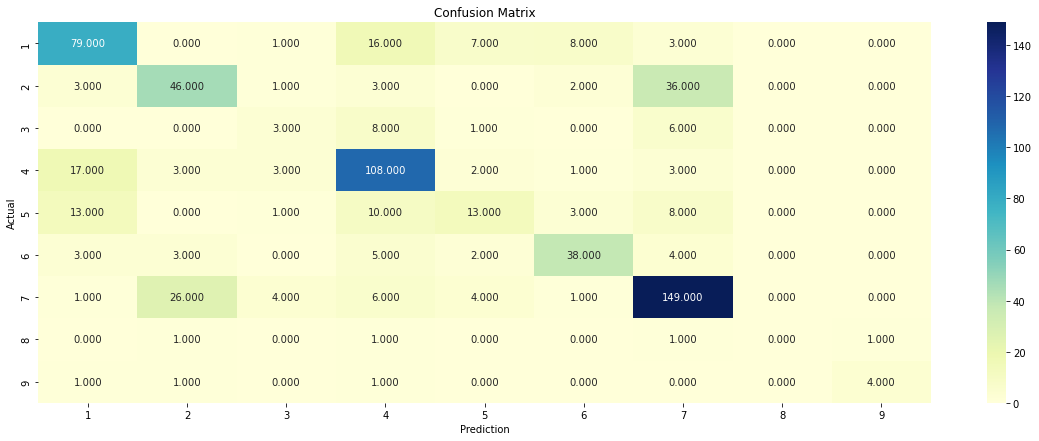

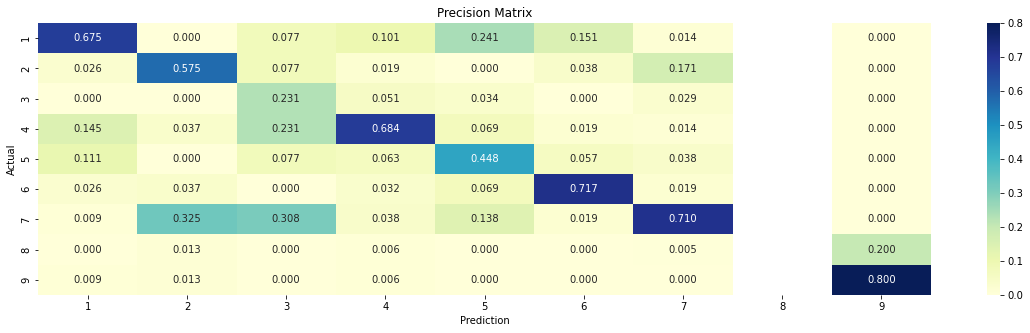

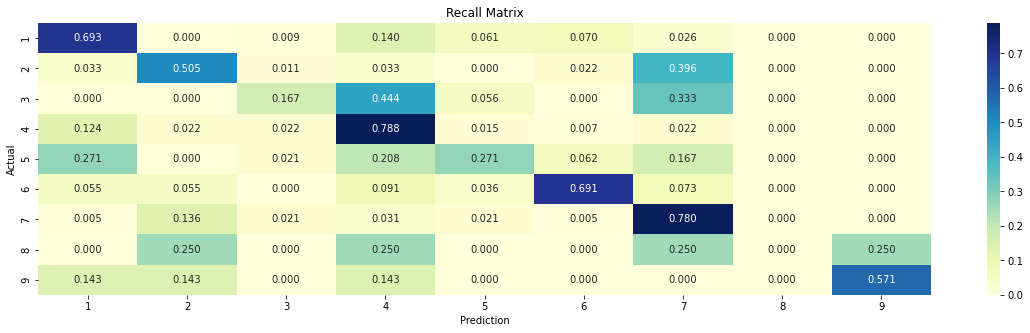

In [74]:
conufsion_precision_recall(y_test,knn_test_predict)

# Random Forest: Hyperparameter tuning

https://github.com/karndeepsingh/optuna/blob/master/Optuna.ipynb

In [75]:
def objective(trial):

    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    max_depth = trial.suggest_int("max_depth", 2, 100, log=True)
    n_estimators = trial.suggest_int("n_estimators", 5,500)
    min_samples_split = trial.suggest_int("min_samples_split", 2,32)

    rf = RandomForestClassifier(criterion =criterion,max_depth=max_depth, n_estimators=n_estimators)

    score = cross_val_score(rf, X_train, y_train, n_jobs=-1, cv=5,scoring = 'f1_weighted')
    accuracy = score.mean()
    return accuracy

In [76]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

[I 2022-08-29 21:07:08,234] A new study created in memory with name: no-name-382529d2-a990-4696-9864-3f6bb65eea9a
[I 2022-08-29 21:08:56,786] Trial 0 finished with value: 0.8834781225669495 and parameters: {'criterion': 'entropy', 'max_depth': 25, 'n_estimators': 263, 'min_samples_split': 27}. Best is trial 0 with value: 0.8834781225669495.
[I 2022-08-29 21:09:14,384] Trial 1 finished with value: 0.7786816142356943 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 118, 'min_samples_split': 9}. Best is trial 0 with value: 0.8834781225669495.
[I 2022-08-29 21:09:25,087] Trial 2 finished with value: 0.8776210176966659 and parameters: {'criterion': 'entropy', 'max_depth': 16, 'n_estimators': 29, 'min_samples_split': 6}. Best is trial 0 with value: 0.8834781225669495.
[I 2022-08-29 21:09:43,369] Trial 3 finished with value: 0.8840112869321878 and parameters: {'criterion': 'entropy', 'max_depth': 22, 'n_estimators': 51, 'min_samples_split': 12}. Best is trial 3 with va

In [77]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

Accuracy: 0.9034770091546334
Best hyperparameters: {'criterion': 'gini', 'max_depth': 60, 'n_estimators': 194, 'min_samples_split': 22}


# Fitting model on best hyperparameters:

In [78]:
rf_best = RandomForestClassifier(n_estimators= 130, min_samples_split= 15, max_depth = 19, criterion = 'gini', random_state = 0)
rf_best.fit(X_train,y_train)

rf_train_predict = rf_best.predict(X_train)
rf_test_predict = rf_best.predict(X_test)

train_f2 = (fbeta_score(y_train,rf_train_predict,beta = 2,average = 'weighted'))
test_f2 = (fbeta_score(y_test,rf_test_predict,beta = 2,average = 'weighted'))

print("Train F2 score = {}".format(train_f2))
print("Test F2 score = {}".format(test_f2))

Train F2 score = 0.9851629896620618
Test F2 score = 0.6892271076151478


In [79]:
sig_clf_rf = CalibratedClassifierCV(rf_best, method="sigmoid") # getting prediction in form of probabilities
sig_clf_rf.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=19,
                                                             min_samples_split=15,
                                                             n_estimators=130,
                                                             random_state=0))

# Evaluation: 

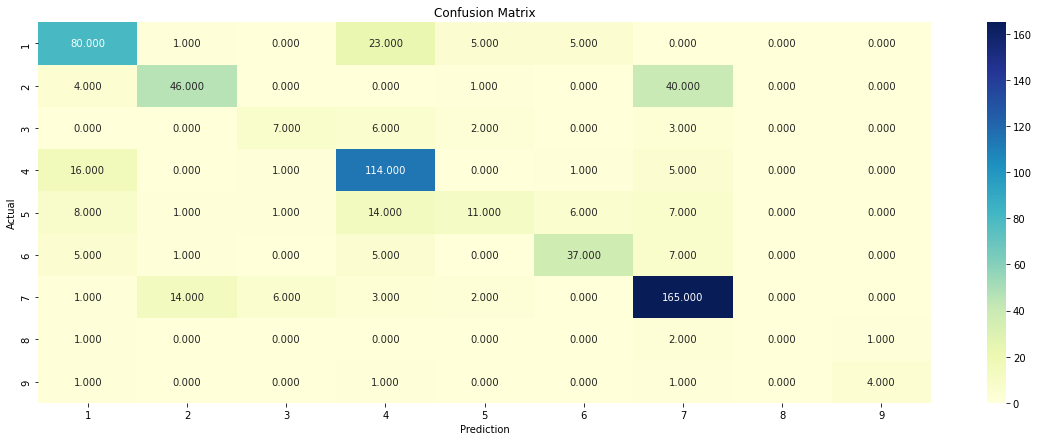

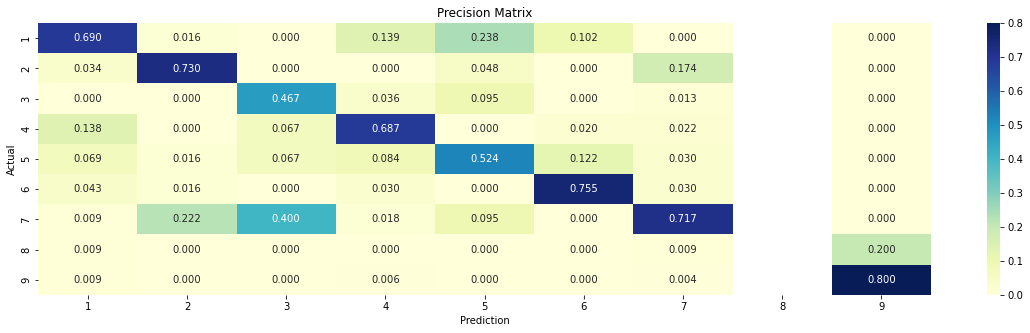

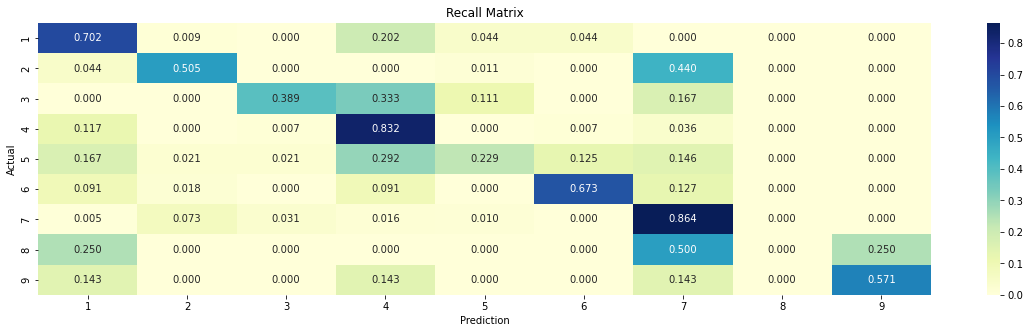

In [80]:
conufsion_precision_recall(y_test, rf_test_predict)

# Interpretability:

In [81]:
i = random.randint(0,len(y_test)) # randomly generate an index from the test dataset
actual = y_test.values[i] # actual class
prob = sig_clf_rf.predict_proba(X_test[i]) # this gives the probability values for 9 classes
predict = np.argmax(prob) + 1 
print('Actual Class:',actual)
print('*'*100)
print('Probability values to interpret:',prob)
print('*'*100)
print('Predicted Class:',predict)

Actual Class: 7
****************************************************************************************************
Probability values to interpret: [[0.00597562 0.26401831 0.01882758 0.00853929 0.01558624 0.03275199
  0.63639101 0.00893553 0.00897443]]
****************************************************************************************************
Predicted Class: 7


# Comparing F2 score for all techniques used:

In [83]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ["Model","Vectorizer(Gene & Variation)","Vectorizer(TEXT)","F2 Score","Number of features"]
x.add_row(["Naive Bayes", 'Response Coding','TF-IDF', 0.59 ,3])
x.add_row(["KNN",'Response Coding','TF-IDF',0.66,3])
x.add_row(["Random Forest", 'Response Coding','TFIDF', 0.67 ,3])
x.add_row(["KNN", 'Response Coding','BERT', 0.59 ,3])
x.add_row(["Random Forest",'Response Coding','BERT',0.6387,3])
x.add_row(["KNN", 'Cat Boost','BERT', 0.548 ,3])
x.add_row(["Random Forest", 'Cat Boost','BERT', 0.5520 ,3])
x.add_row(["Naive Bayes", 'Response Coding','TF-IDF', 0.595 ,10])
x.add_row(["KNN", 'Response Coding','TF-IDF', 0.656 ,10])
x.add_row(["Random Forest", 'Response Coding','TF-IDF', 0.69 ,10])

(x)

Model,Vectorizer(Gene & Variation),Vectorizer(TEXT),F2 Score,Number of features
Naive Bayes,Response Coding,TF-IDF,0.59,3
KNN,Response Coding,TF-IDF,0.66,3
Random Forest,Response Coding,TFIDF,0.67,3
KNN,Response Coding,BERT,0.59,3
Random Forest,Response Coding,BERT,0.6387,3
KNN,Cat Boost,BERT,0.548,3
Random Forest,Cat Boost,BERT,0.552,3
Naive Bayes,Response Coding,TF-IDF,0.595,10
KNN,Response Coding,TF-IDF,0.656,10
Random Forest,Response Coding,TF-IDF,0.69,10


In [84]:
import pickle
  
pickle.dump(rf_best,open('model.pkl','wb'))